Example notebook for running the scripted ICA.

In [1]:
from astropy.io import fits
import sys
sys.path.append("/Users/trevormccaffrey/Dropbox/ICA_module/")
#sys.path.append("/Users/Trevor1/Dropbox/ICA_module/")
import run_ICA_r20_components
sys.path.append("/Users/trevormccaffrey/Dropbox/HST/HSTCode/")
import Cut_Edge_Pix_TVM
import Small_Pix_Filter_TVM
import spec_morph
import plot_ICA
import matplotlib.pyplot as plt
import numpy as np

First test on a $z\sim2$ SDSS quasar.  This is the "base case" that should definitely work!

In [2]:
!ls

__pycache__
components
icascript_example.ipynb
icascript_preprocess_example-Copy1.ipynb
icascript_preprocess_example.ipynb
icascript_rebin.ipynb
plot_ICA.py
run_ICA_r20_components.py
spec-6715-56449-0294.fits


In [3]:
spec = fits.open("spec-6715-56449-0294.fits")
zSDSS = 1.99703

waveSDSS = 10.**spec[1].data["LOGLAM"] / (1+zSDSS)
fluxSDSS = spec[1].data["FLUX"] ; norm_coeff = np.nanmedian(fluxSDSS) ; fluxSDSS /= norm_coeff
errsSDSS = 1. / np.sqrt(spec[1].data["IVAR"]) ; errsSDSS /= norm_coeff
maskSDSS = spec[1].data["AND_MASK"]
maskSDSS[maskSDSS>0] = 1. 

/Users/trevormccaffrey/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:6: RuntimeWarning: divide by zero encountered in true_divide
  


In [4]:
np.unique(maskSDSS)

array([0, 1], dtype=int32)

First mask bad pix or morph?

For now, I will try to mask NALs before the initial fit.

In [5]:
flux_median_61p = Small_Pix_Filter_TVM.SDSS_pixel_filter(waveSDSS, fluxSDSS, 61)

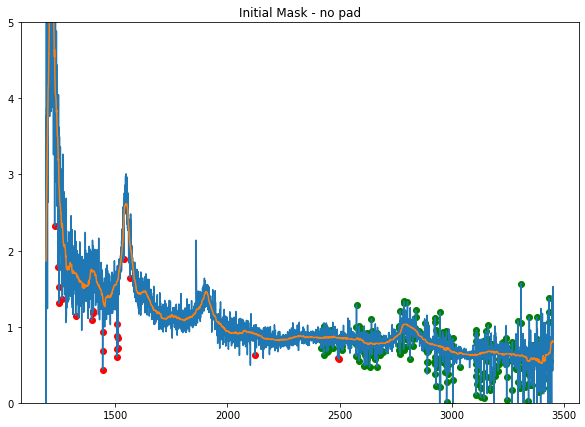

In [6]:
fig = plt.figure(figsize=(10,7))
plt.plot(waveSDSS, fluxSDSS)
plt.plot(waveSDSS, flux_median_61p)
plt.scatter(waveSDSS[(flux_median_61p-fluxSDSS > 3*errsSDSS)], 
            fluxSDSS[(flux_median_61p-fluxSDSS > 3*errsSDSS)], color="r", label="NAL candidates")
plt.scatter(waveSDSS[maskSDSS>0], fluxSDSS[maskSDSS>0], color="g", label="SDSS mask")
plt.ylim(0,5)
plt.title("Initial Mask - no pad")
plt.show()

In [7]:
maskSDSS[(flux_median_61p-fluxSDSS > 3*errsSDSS)] = 2.

In [8]:
#Pad the NAL mask three pixels each side
for i in range(len(waveSDSS)):
    if maskSDSS[i]==2.:
        maskSDSS[i-3:i+3+1] = 3. #this keeps from masking the entire spectrum in the for loop!
maskSDSS[maskSDSS==3] = 2 #save them all as two

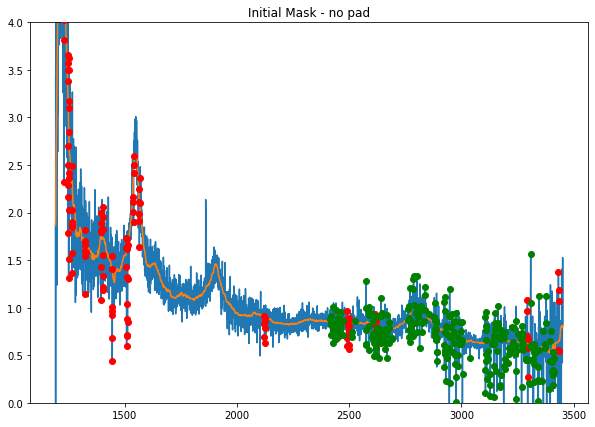

In [9]:
fig = plt.figure(figsize=(10,7))
plt.plot(waveSDSS, fluxSDSS)
plt.plot(waveSDSS, flux_median_61p)
plt.scatter(waveSDSS[maskSDSS==2], 
            fluxSDSS[maskSDSS==2], color="r", label="NAL candidates", zorder=3)
plt.scatter(waveSDSS[maskSDSS==1], fluxSDSS[maskSDSS==1], color="g", label="SDSS mask", zorder=3)
plt.ylim(0,4)
plt.title("Initial Mask - no pad")
plt.show()

In [10]:
wave_ica, flux_ica = run_ICA_r20_components.main_ICA(waveSDSS, fluxSDSS, errsSDSS, maskSDSS, name="", 
                                                     ica_path="/Users/trevormccaffrey/Dropbox/ICA_module/components/",
                                                     plot_spectrum=False, CHISQ=True, comps_use=None)

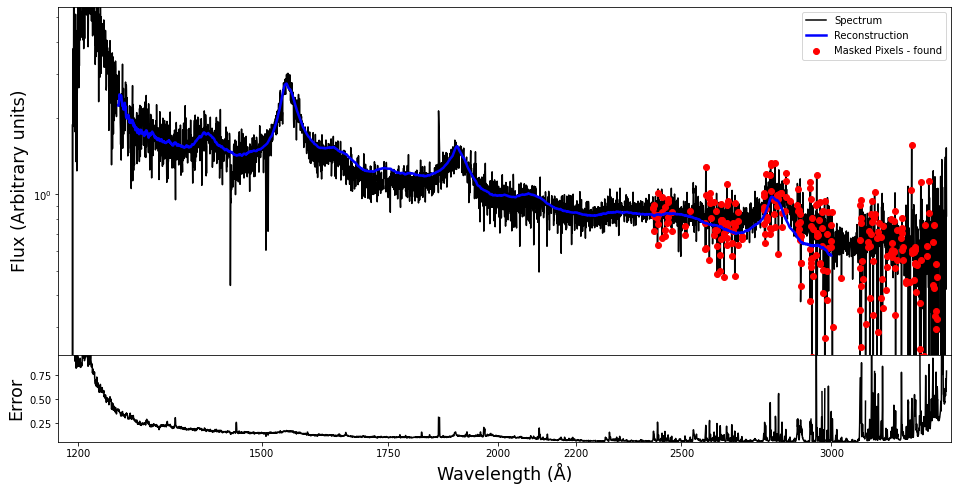

In [11]:
plot_ICA.spec_wreconstruction(waveSDSS, fluxSDSS, errsSDSS, maskSDSS, wave_ica, flux_ica)

Now morph

In [12]:
fluxSDSS_morph, morph_coeff = spec_morph.morph2(waveSDSS*(1+zSDSS), fluxSDSS, errsSDSS, zSDSS, "Identifier")
errsSDSS_morph = errsSDSS * morph_coeff

In [13]:
wave_morph_ica, flux_morph_ica = run_ICA_r20_components.main_ICA(waveSDSS, fluxSDSS_morph, errsSDSS_morph, maskSDSS, name="", 
                                             ica_path="/Users/trevormccaffrey/Dropbox/ICA_module/components/",
                                             plot_spectrum=False, CHISQ=True, comps_use=None)

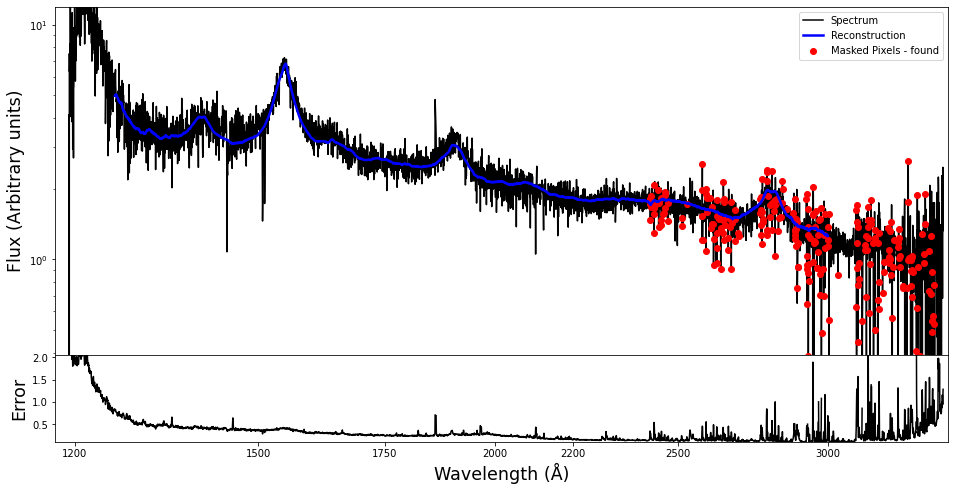

In [14]:
plot_ICA.spec_wreconstruction(waveSDSS, fluxSDSS_morph, errsSDSS_morph, maskSDSS, wave_morph_ica, flux_morph_ica)

---

Now see how spectrum changes with iterative masking.  This should be implemented in the actual script eventually, but want to visualize how things change with each step for now.

In [15]:
maskSDSS_witer = run_ICA_r20_components.maskIterate(waveSDSS, fluxSDSS_morph, errsSDSS_morph, maskSDSS, 
                                                    wave_morph_ica, flux_morph_ica)

In [16]:
wave_morph_witer_ica, flux_morph_witer_ica = run_ICA_r20_components.main_ICA(waveSDSS, fluxSDSS_morph, 
                                                                             errsSDSS_morph, maskSDSS_witer, 
                                                                             name="", 
                                             ica_path="/Users/trevormccaffrey/Dropbox/ICA_module/components/",
                                             plot_spectrum=False, CHISQ=True, comps_use=None)

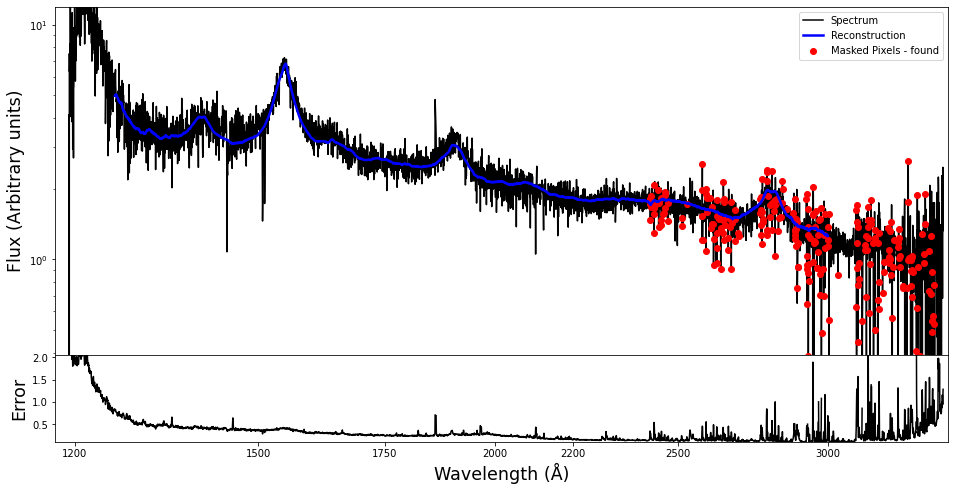

In [17]:
plot_ICA.spec_wreconstruction(waveSDSS, fluxSDSS_morph, errsSDSS_morph, maskSDSS_witer, 
                              wave_morph_witer_ica, flux_morph_witer_ica)